# Компания «Работа с заботой»: оценка уровня удовлетворенности сотрудников

## Введение

**Цель работы:**
1. Оценить уровень удовлетворенности каждого сотрудника.
2. Оценить вероятность увольнения каждого сотрудника.

**Задачи, направленные для достижения цели:**
1. Проанализировать предоставленные данные на наличие выбросов, пропусков, аномальных значений.
2. Провести исследовательских и корреляционный анализ данных.
3. Сформировать признаки для обучения моделей.
4. Сформировать и обучить две модели: первая модель для предсказания уровня удовлетворенности, вторая модель - для предсказания вероятности увольнения сотрудника.

**План работы:**
1. Загрузить данные.
2. Проверить данные на наличие пропусков, выбросов и аномальных значений.
3. Провести исследовательский анализ данных.
4. Провести корреляционный анализ данных.
5. Сформировать и обучить модель для прогноза уровня удовлетворенности.
6. Проверить качество работы модели на тестовых данных.
7. Сформировать и обучить модель для прогноза вероятности увольнения сотрудника.
8. Проверить качество работы модели на тестовых данных.
9. Подвести итоги и сформировать выводы.

**Описание предоставленных данных**  
Предоставлено 5 таблиц с данными.
1. train_job_satisfaction_rate.csv - тренировочная выборка для обучения модели по прогнозированию уровня удовлетворенности.
2. test_features.csv - входные признаки тестовой выборки для проверки качества моделей.
3. test_target_job_satisfaction_rate.csv - целевой признак тестовой выборки для оценки качества модели по прогнозированию уровня удовлетворенности.
4. train_quit.csv - тренировочная выборка для обучения модели по прогнозированию вероятности увольнения.
5. test_target_quit.csv - целевой признак тестовой выборки для оценки качества модели по прогнозированию вероятности увольнения.

   Столбцы, присутствующие в таблицах:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

**Оценка качества моделей**  
Для оценки качества модели прогнозирования уровня удовлетворенности будет использоваться метрика SMAPE, рассчитываемая из следующих показателей:
- фактическое значение уровня удовлетворенности для объекта из выборки;
- предсказанное значение уровня удовлетворенности для объекта из выборки;
- количество объектов в выборке.
Критерием успеха модели является SMAPE ≤15 на тестовой выборке.

Модель прогнозирования вероятности увольнения будет оцениваться по метрике ROC-AUC.
Критерий успеха: ROC-AUC ≥ 0.91.

**Пояснение к работе**  
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.
Для этих целей HR-аналитикам необходимы модели, с помощью которых они смогут прогнозировать уровни удовлетворенности сотрудников, а также вероятность их увольнения.
Уровень удовлетворенности, представленный в тестовых таблицах, получен в результате опроса сотрудников и рассчитан в диапазоне от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.
Прогнозировать уровень удовлетворенности и вероятность увольнения сотрудника крайне важно для компании, так как в случае увольнения важного сотрудника возрастает риск возникновения серъезных убытков.


## Загрузка данных

### Загрузка библиотек и функций

Сперва загрузим необходимые библиотеки.

In [ ]:
! pip install phik
!pip install shap

     |████████████████████████████████| 686 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 540 kB 2.6 MB/s eta 0:00:01


In [ ]:
# Стандартные библиотеки
import pandas as pd
import numpy as np

# Библиотеки для работы с графиками
import matplotlib.pyplot as plt
import seaborn as sns


# Библиотеки для анализа данных
import phik
from phik.report import plot_correlation_matrix
from phik import report
import plotly.express as px
import shap

# Библиотеки для работы с моделями
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score, make_scorer,
    f1_score,
    roc_auc_score
)

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import svm

# Обработка предупреждений
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def lunge_analysis(df, columns, groups, hue):
    """
    Функция строит боксплоты и гистограммы по переданному списку столбцов и с группировкой по одному категориальному признаку.

    Параметры:
        df: датафрейм с нужными значениями.
        columns: список названий столбцов, по которым надо построить диаграммы.
        groups: столбец из датафрейма с категориальными значениями.

    Возвращает:
        Оформленные боксплоты и гистограммы.

    """
    for column in columns:
        f, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax_1 = sns.histplot(data=df, x=column, hue=hue, ax=ax[0])
        ax_1.set (xlabel=column, ylabel='Количество', title=f'Гистограмма по столбцу {column}')
        ax_2 = sns.boxplot(data=df, y=column, ax=ax[1], width=.2)
        ax_2.set (xlabel=column, ylabel='Значение', title=f'Диаграмма размаха признака {column}')
        plt.show()
    for group in groups:
        f, ax = plt.subplots(1, 1, figsize=(10, 8))
        ax_3 = plt.pie(df[group].value_counts(), labels=df[group].value_counts().index.tolist(), colors=sns.color_palette('bright'), autopct='%.0f%%')
        plt.title(f'Круговая диаграмма для признака {group}')
        plt.show()

In [ ]:
def search_duplicate(df, columns):
    print(f'Количество полных дубликатов в датафрейме:{df.duplicated().sum()}')
    print(f'Количество дубликатов в столбце id в датафрейме:{df["id"].duplicated().sum()}')
    for column in columns:
        print(f'Уникальные значения в столбце {column}: {df[column].unique()}')

In [ ]:
# создаём функцию для оценки качества модели методом SMAPE
def custom_metric(y_true, y_pred):
    """
    Считает метрику SMAPE.

    Параметры:
        y_true: массив с истинными значениями.
        y_pred: массив с предсказанными значениями.

    Возвращает:
        Значение метрики.

    """
    summ_fraction = 0
    for i in range(len(y_true)):
        summ_fraction += abs(y_true[i] - y_pred[i]) / ((abs(y_true[i]) + abs(y_pred[i])) / 2)
    metric = (100 / y_true.count()) * summ_fraction
    return metric

In [ ]:
def cat_quit(df):
    if df['quit'] == 'yes':
        return 1
    else:
        return 0

def cat_quit_pred(df):
    if df['quit_pred'] == 'yes':
        return 1
    else:
        return 0


## Задание 1. Прогнозирование уровня удовлетворенности

### Загрузка данных из таблиц

На основании предоставленных таблиц создадим датафреймы.

In [ ]:
df_train_satisfaction = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')  # Тренировочная выборка
df_test_features_satisfaction = pd.read_csv('/datasets/test_features.csv')  # Входные признаки тестовой выборки
df_test_target_satisfaction = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')  # Целевой признак тестовой выборки

Просмотрим данные.

In [ ]:
df_train_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [ ]:
df_train_satisfaction.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [ ]:
df_test_features_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [ ]:
df_test_features_satisfaction.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
df_test_target_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [ ]:
df_test_target_satisfaction.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


В двух датафреймах есть пропуски. Пропуски есть в следующих столбцах:
- dept. В датафрейме df_train_satisfaction пропусков 6, в df_test_features_satisfaction - 2
- level. В датафрейме df_train_satisfaction пропусков 2, в df_test_features_satisfaction - 1.  

Данные пропуски заполним ниже в Pipeline.

**Итог по разделу:** Все данные загружены, типы присвоены корректны, определено, что в данных есть пропуски.

### Предобработка данных

Проверим данные на наличие дубликатов, как явных, так и неявных. Сперва явные дубликаты:

In [ ]:
print(f'Количество дубликатов в df_train_satisfaction:{df_train_satisfaction.duplicated().sum()}')
print(f'Количество дубликатов в df_test_features_satisfaction:{df_test_features_satisfaction.duplicated().sum()}')
print(f'Количество дубликатов в df_test_target_satisfaction:{df_test_target_satisfaction.duplicated().sum()}')

Количество дубликатов в df_train_satisfaction:0
Количество дубликатов в df_test_features_satisfaction:0
Количество дубликатов в df_test_target_satisfaction:0


Полных явных дубликатов нет. Проверим наличие дубликатов по отдельным столбцам.

In [ ]:
print(f'Количество дубликатов в столбце id в df_train_satisfaction:{df_train_satisfaction["id"].duplicated().sum()}')
print(f'Количество дубликатов в столбце id в df_test_features_satisfaction:{df_test_features_satisfaction["id"].duplicated().sum()}')
print(f'Количество дубликатов в столбце id в df_test_target_satisfaction:{df_test_target_satisfaction["id"].duplicated().sum()}')

Количество дубликатов в столбце id в df_train_satisfaction:0
Количество дубликатов в столбце id в df_test_features_satisfaction:0
Количество дубликатов в столбце id в df_test_target_satisfaction:0


Задвоенных id нет. В других столбцах могут быть неуникальные значения.

Проверим на неявные дубликаты. Сперва создадим перечень столбцов, в которых будем искать дубликаты. Для поиска дубликатов воспользуемся собственной функцией.

In [ ]:
columns_duplicate = ['dept', 'level', 'workload']

In [ ]:
search_duplicate(df_train_satisfaction, columns_duplicate)

Количество полных дубликатов в датафрейме:0
Количество дубликатов в столбце id в датафрейме:0
Уникальные значения в столбце dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения в столбце level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце workload: ['medium' 'high' 'low']


In [ ]:
search_duplicate(df_test_features_satisfaction, columns_duplicate)

Количество полных дубликатов в датафрейме:0
Количество дубликатов в столбце id в датафрейме:0
Уникальные значения в столбце dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения в столбце level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце workload: ['medium' 'low' 'high' ' ']


Интересный факт. В столбце dept есть значение с пробелом. Посмотрим на него.

In [ ]:
df_test_features_satisfaction.loc[df_test_features_satisfaction['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


Заменим это значение на пропуск.

In [ ]:
df_test_features_satisfaction['dept'] = df_test_features_satisfaction['dept'].replace(' ', np.NaN)

In [ ]:
df_test_features_satisfaction['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

Замена проведена.

**Итог по разделу:** Дубликаты обработаны.

### Исследовательский анализ данных

Для исследования столбцов воспользуемся функцией lunge_analysis. Сперва сформируем список столбцов.

In [ ]:
an_columns_satis = ['employment_years',
                    'supervisor_evaluation',
                    'salary',
                    'job_satisfaction_rate'
                   ]

In [ ]:
group_satis = ['dept',
               'level',
               'workload',
               'last_year_promo',
               'last_year_violations'
              ]

#### Анализ df_train_satisfaction

Построим диаграммы по датафрейму df_train_satisfaction (данные для обучения модели).

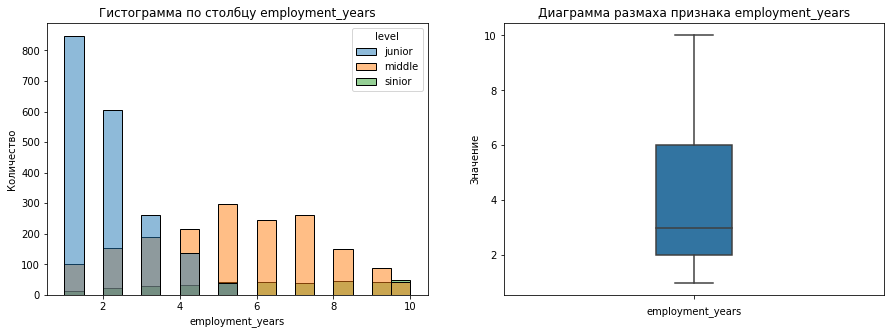

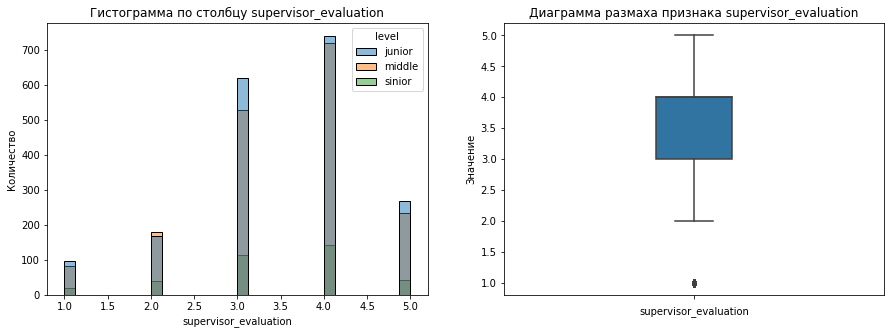

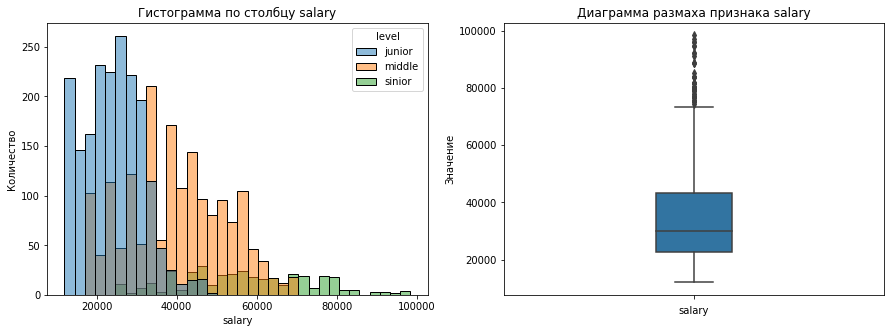

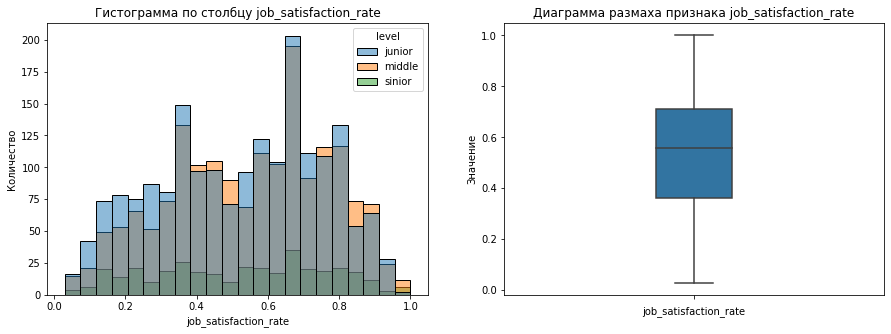

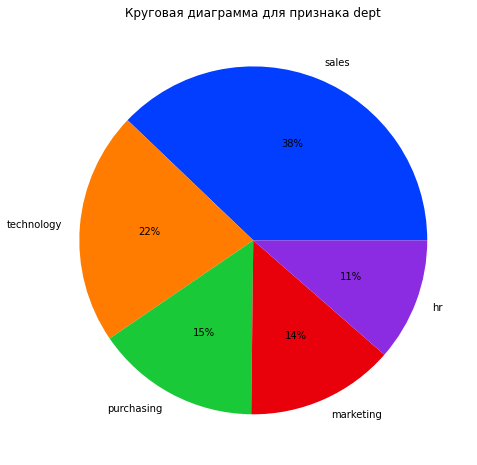

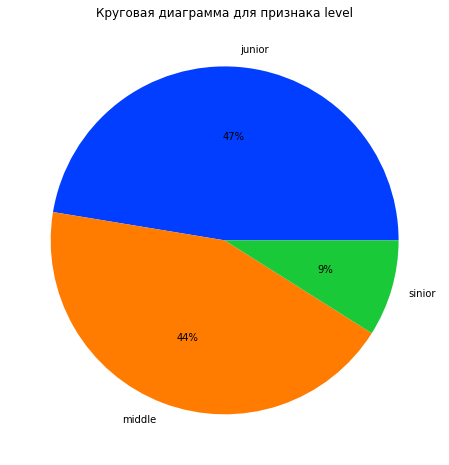

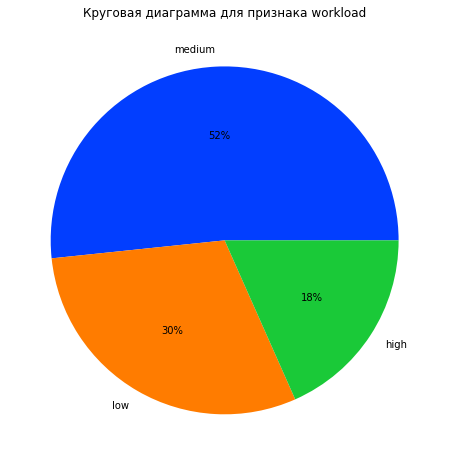

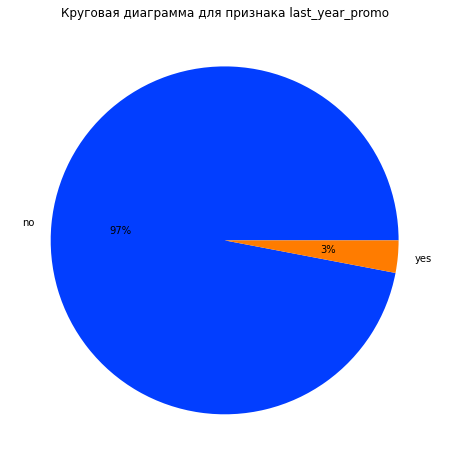

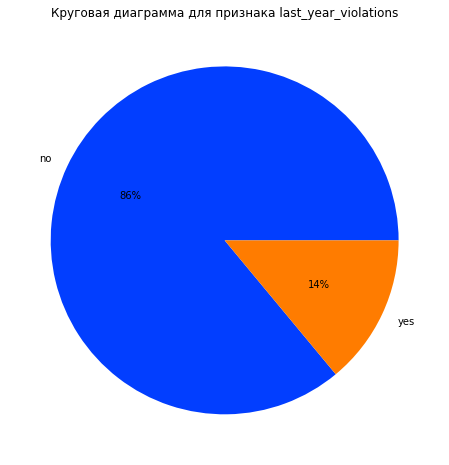

In [ ]:
lunge_analysis(df_train_satisfaction, an_columns_satis, group_satis, 'level')

Очевидно следующее:
1. В столбце supervisor_evaluation есть значения, которые значительно отклоняются от средних (выпады).
2. В столбце salary есть значения, которые значительно отклоняются от средних (выпады).
3. Распределения почти все унимодальные, кроме признака job satisfaction rate. Здесь наблюдается два пика: при 0,38 и при 0,7.
4. В компании наиболее многочисленный отдел это sales.
5. Людей на позициях junior и middle почти одинаковое количество, в то время как senior значительно меньше.
6. В компании у большинства людей средняя загруженность.
7. Всего у 3% сотрудников было повышение за последний год.
8. 14% сотрудников за последний год нарушали трудовой договор.

Посмотрим распределение по признакам.

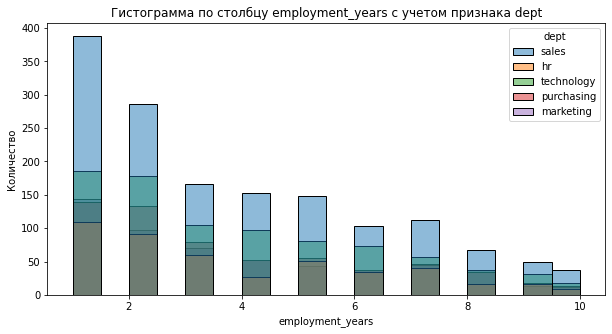

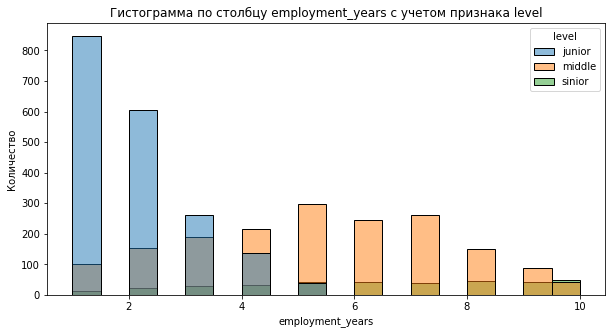

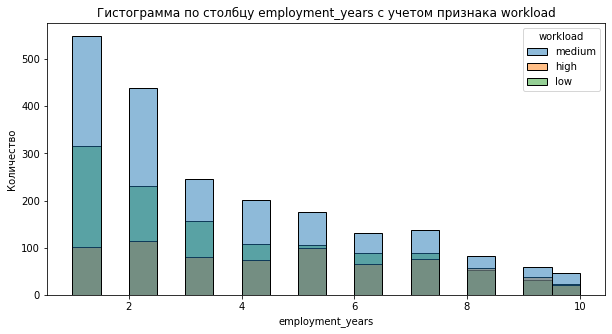

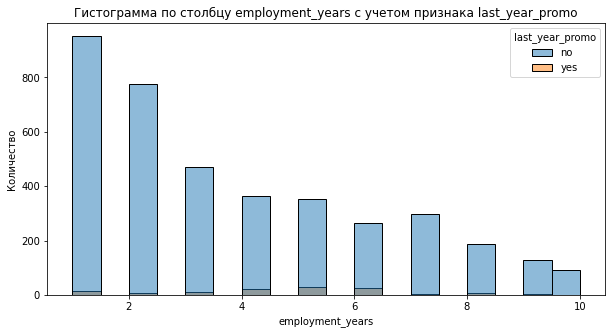

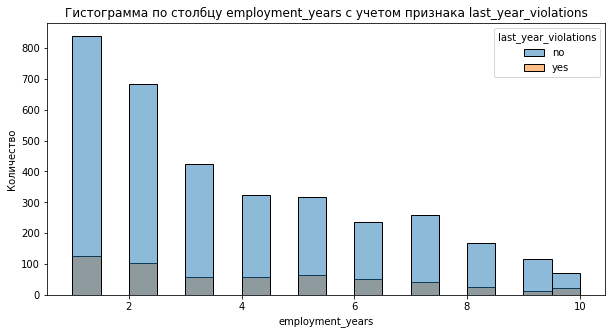

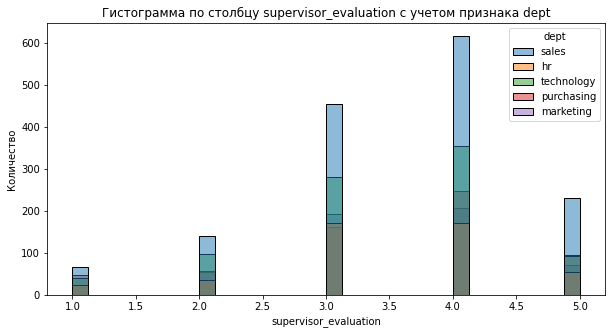

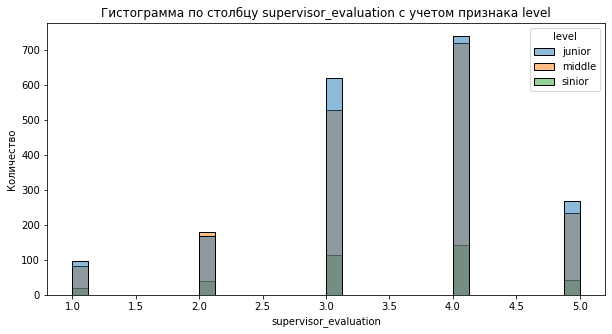

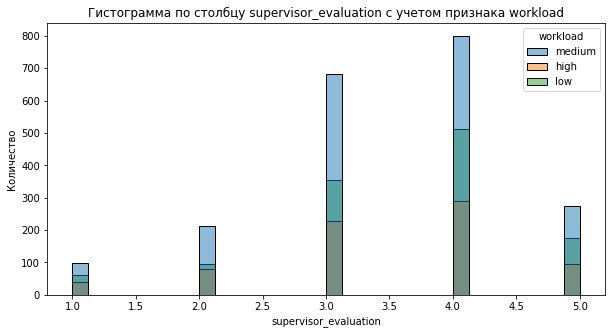

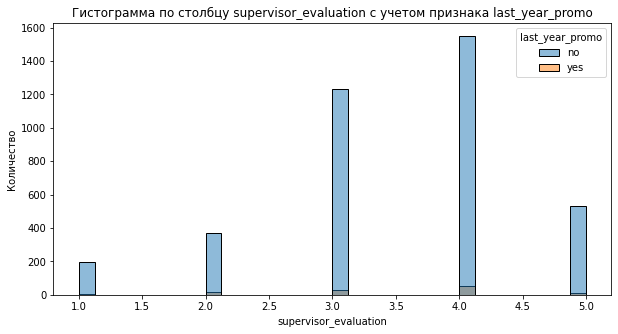

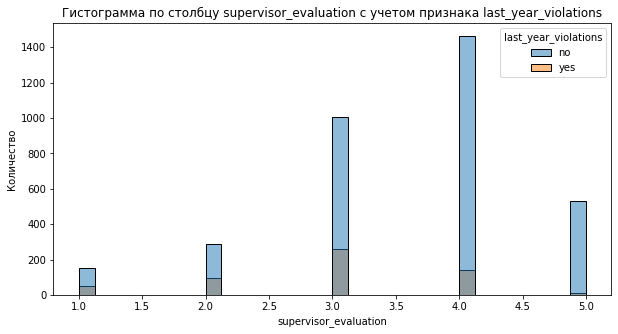

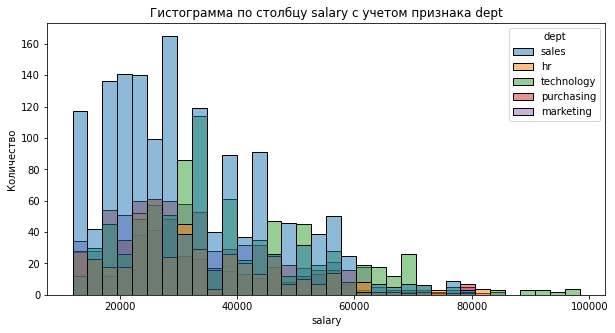

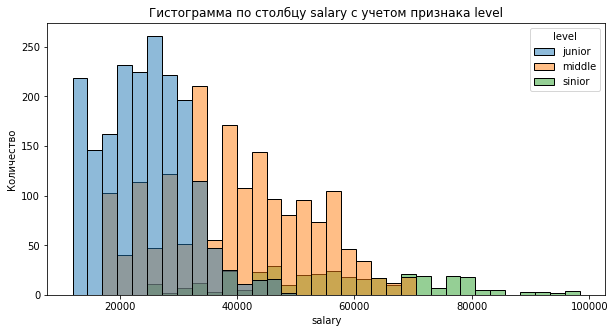

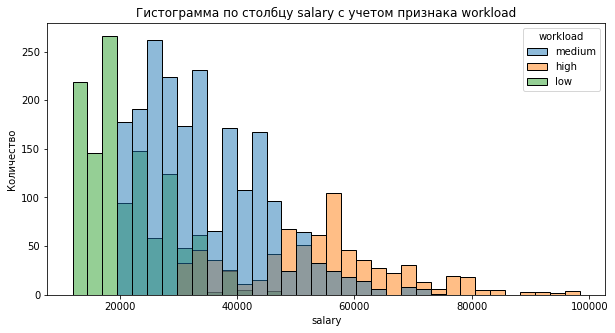

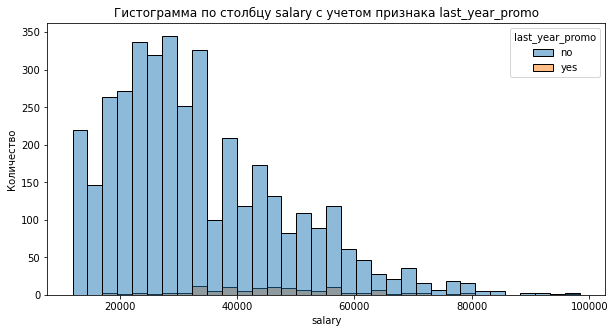

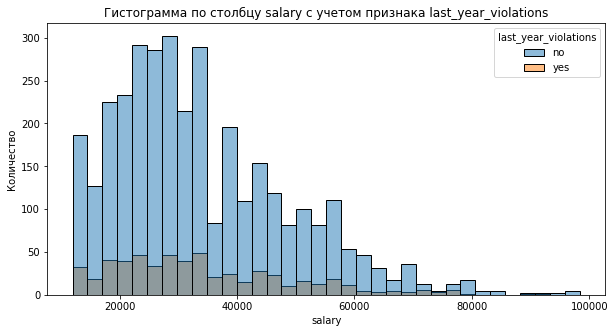

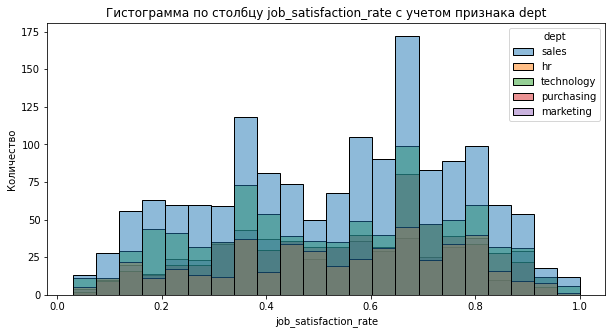

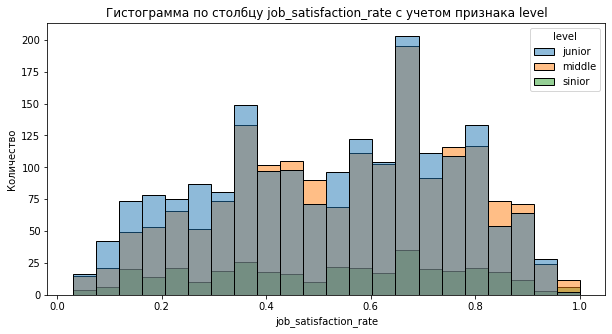

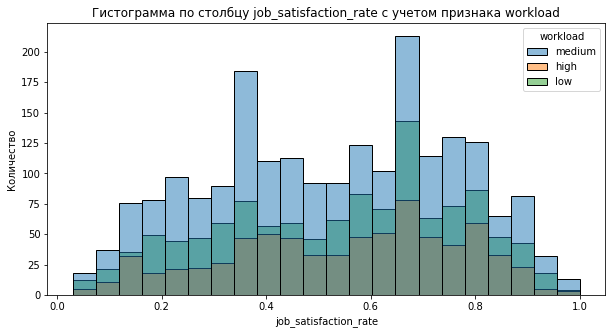

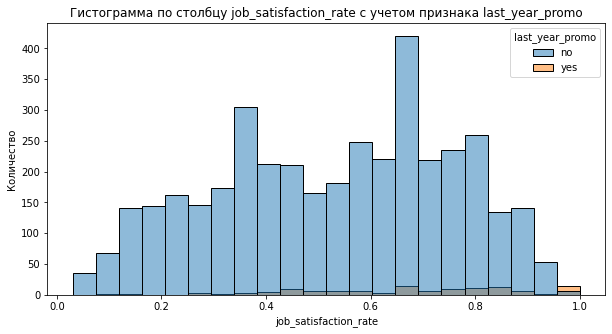

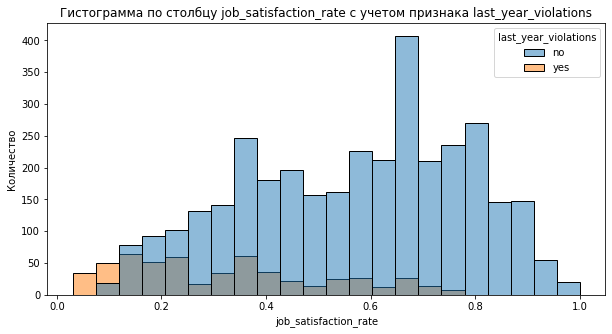

In [ ]:
for column in an_columns_satis:
    for group in group_satis:
        f, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax = sns.histplot(data=df_train_satisfaction, x=column, hue=group)
        ax.set (xlabel=column, ylabel='Количество', title=f'Гистограмма по столбцу {column} с учетом признака {group}')
        plt.show

Из гистограмм с выделенными признаками видно следующее:
1. Во всех отделах соотношение тех, кто долго работает, и тех, кто работает недавно, примерно одинаковое.
2. Люди, которые работают на позиции junior, в большинстве своём работают недолго, до 4 лет. Более 4 лет работают люди, которые занимают позиции middle и junior. Вероятно, за 4 года сотрудники вырастают до более сложных позиций.
3. Примерно одинаковое соотношение по загруженности тех, кто работает долго и тех, кто работает недавно.
4. Относительно чаще всего получают повышение люди, которые работают от 4 до 6 лет.
5. Длительность работы почти не сказывается на количество нарушений трудового договора. Уровень примерно одинаковый для всех групп.
6. Чаще всего сотрудникам руководитель выставляет оценку 4. Данный показатель не зависит от отдела, где работает сотрудник.
7. "Перекоса" в оценке по уровню сотрудника (junior или senior) или по загруженности также не наблюдается. Всё распределено примерно одинаково. То есть, можно сказать, что высокая загруженность редко приводит к высоким оценкам от руководства.
8. Также нельзя сказать, что люди, работу которых оценили на 5, получают повышение чаще других. В общем случае вероятность получения повышение примерно одинаковая вне зависимости от оценки работы.
9. Чаще всего трудовой договор нарушают те, чья оценка работы от 3 и ниже.
10. Наибольшая зарплата у специалистов из технологического отдела, хотя таких людей немного.
11. Наибольшая зарплата у специалистов уровня senior, хотя и среди них тоже встречаются низкооплачиваемые сотрудники.
12. Чем больше загруженность, тем выше зарплата. У людей с низкой загруженностью зарплата небольшая.
13. Чаще всего получают повышение люди с уровнем зарплаты от 30 000 до 65 000.
14. Нарушения трудового договора отмечены равномерны, вне зависимости от уровня зарплаты.
15. Особенности уровня удовлетворенности отмечаются только на  диаграммах о последнем повышении и о нарушение трудового договора. Так, тех, у кого за последний год повысили, уровень удовлетворенности высокий, а те, которые были замечены за нарушением трудового договора уровень удовлетворенности низкий.

#### Анализ df_test_features_satisfaction

Аналогичным образом проанализируем датафрейм df_test_features_satisfaction (данные для проверки качества обучения модели).

In [ ]:
an_columns_features = ['employment_years',
                    'supervisor_evaluation',
                    'salary'
                   ]

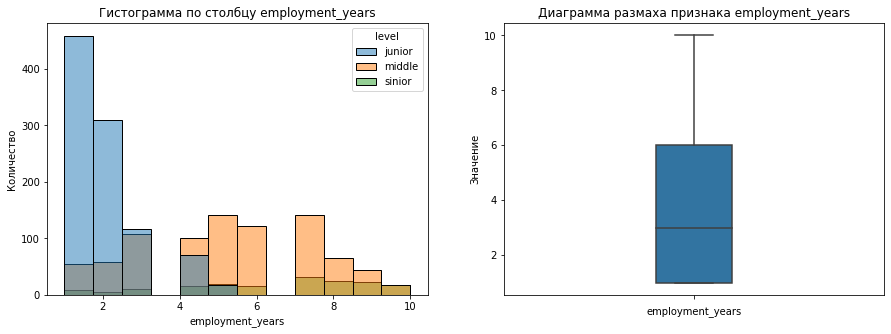

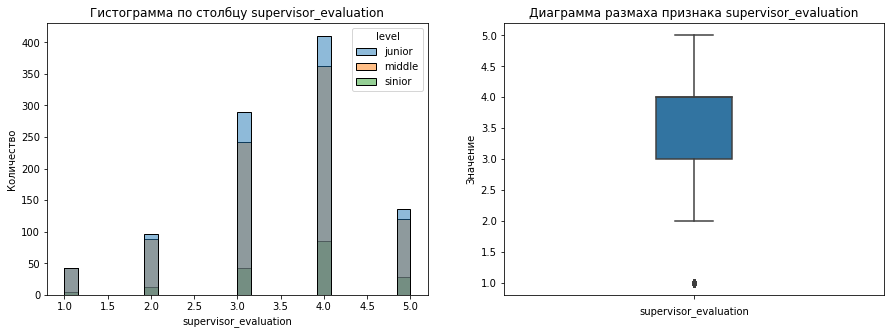

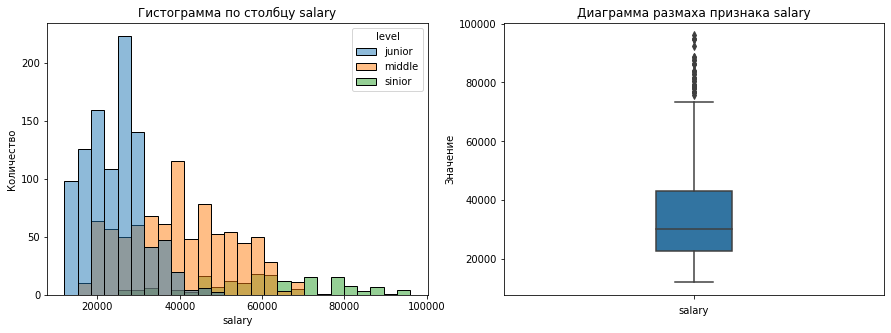

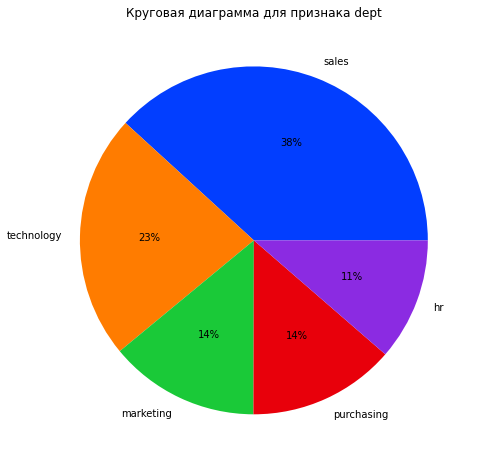

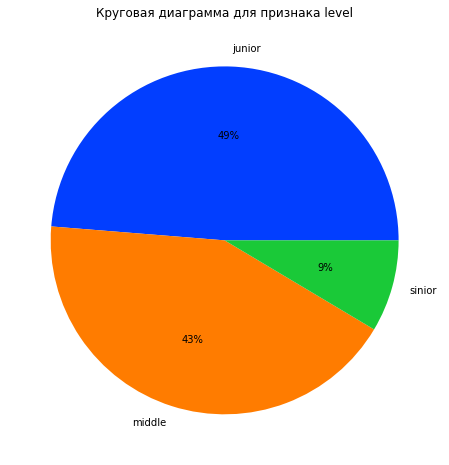

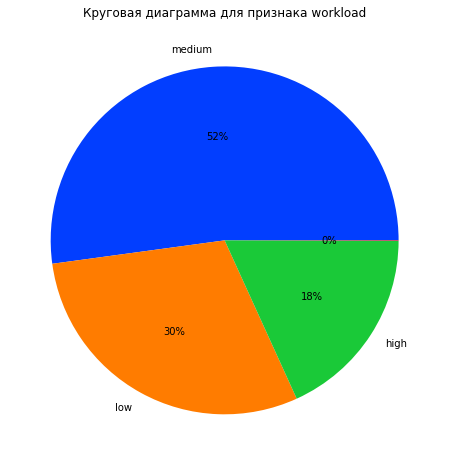

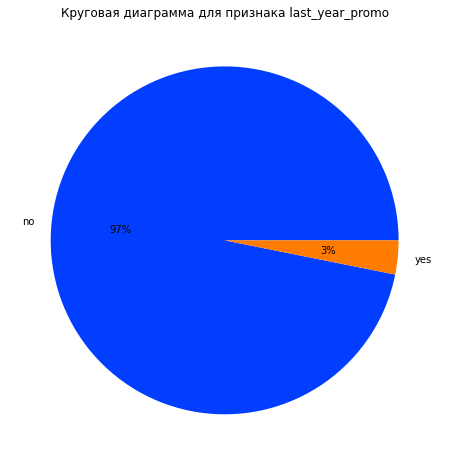

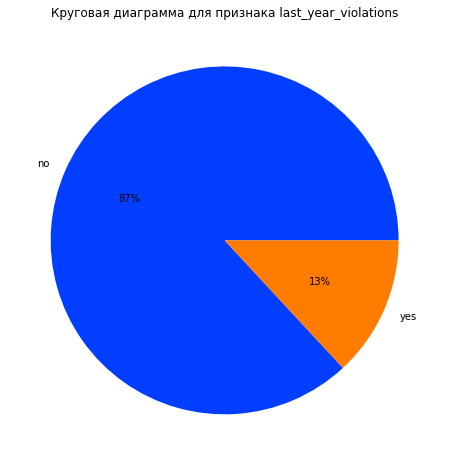

In [ ]:
lunge_analysis(df_test_features_satisfaction, an_columns_features, group_satis, 'level')

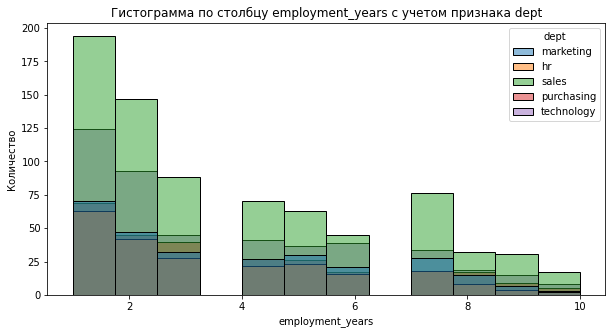

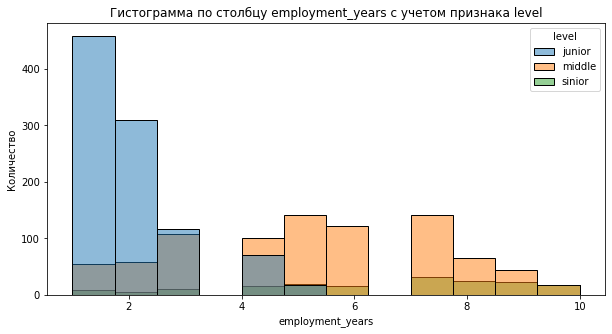

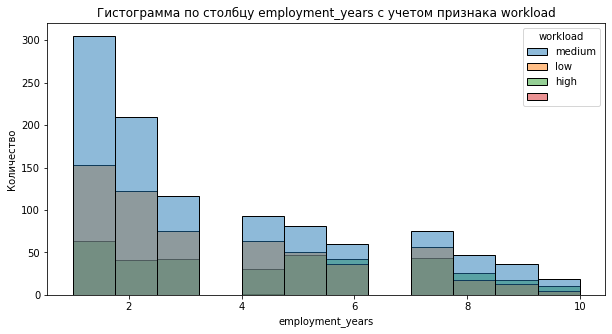

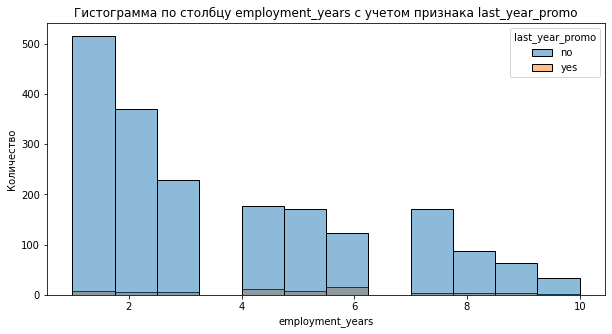

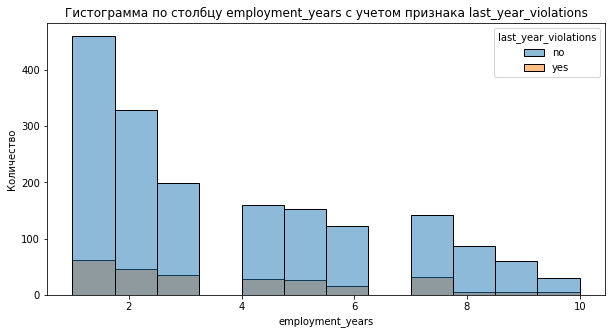

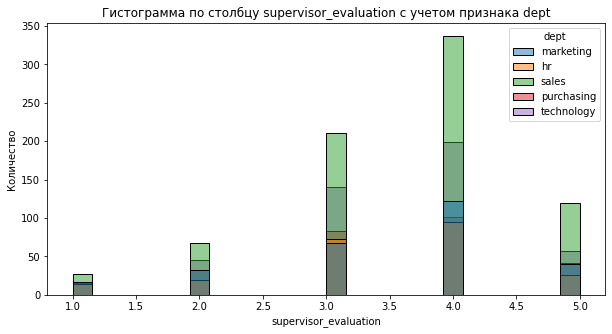

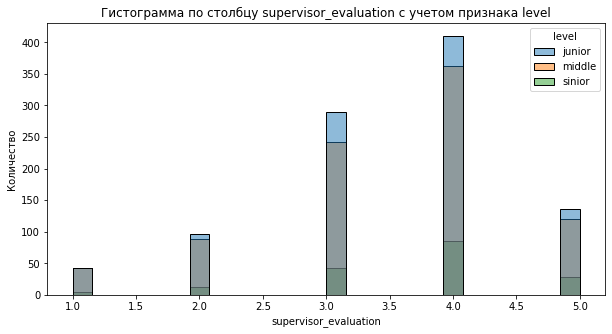

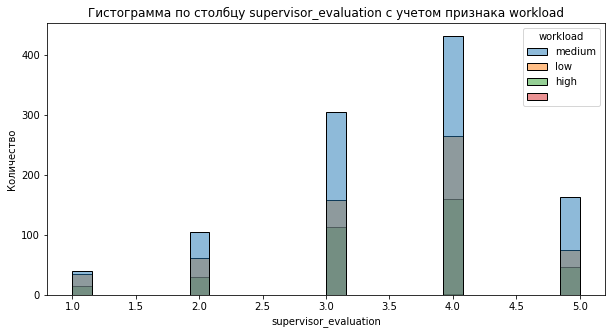

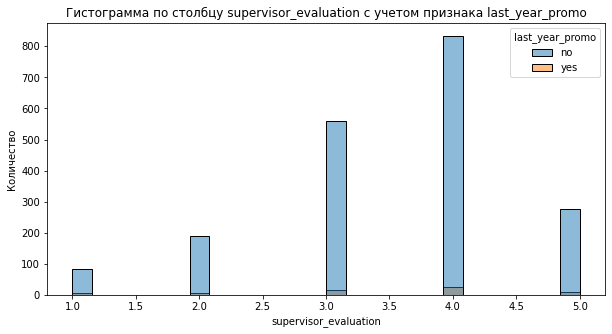

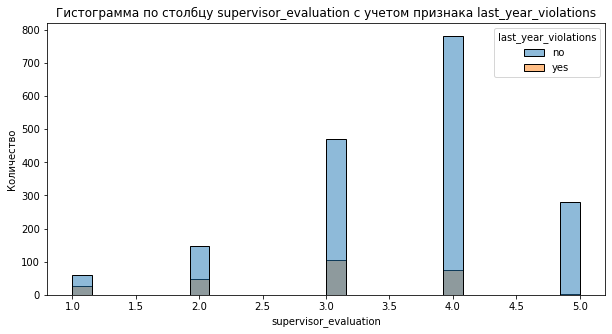

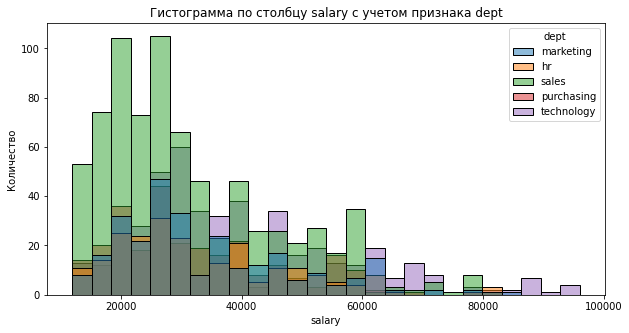

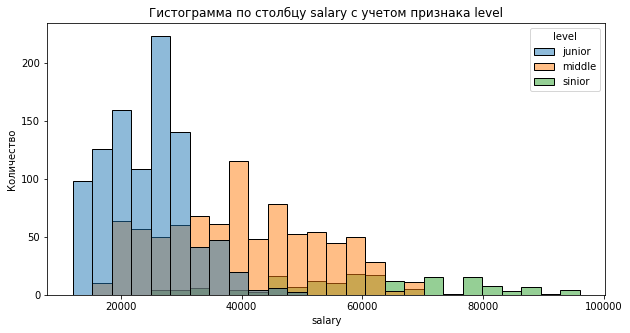

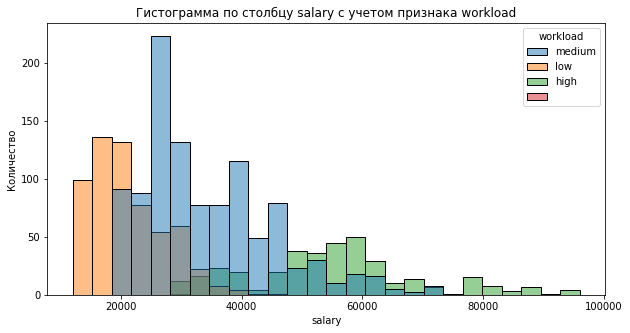

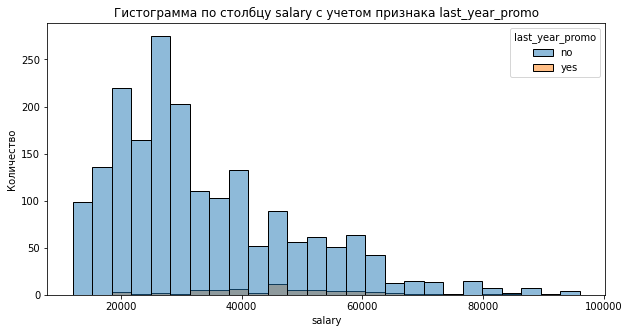

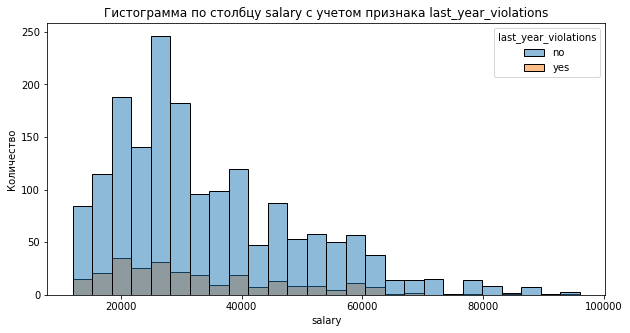

In [ ]:
for column in an_columns_features:
    for group in group_satis:
        f, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax = sns.histplot(data=df_test_features_satisfaction, x=column, hue=group)
        ax.set (xlabel=column, ylabel='Количество', title=f'Гистограмма по столбцу {column} с учетом признака {group}')
        plt.show

В общем виде в датафрейме df_test_features_satisfaction ситуация аналогична df_train_satisfaction: есть выпады и распределения примерно одинаковые.

**Итог по разделу:**
1. В данных, представленных для обучения, и в данных, представленных для проверки качества, распределения практически одинаковые.
2. Имеются выпады в некоторых столбцах. При обучении рекомендуется использовать модели и кодирование признаков, не чувствительные к выпадам.
3. Требуется масштабирование данных.

### Корреляционный анализ

Изучим, как признаки коррелируют между собой. Сформируем перечень признаков для расчета корреляции.

In [ ]:
corr_columns = ['dept',
                'level',
                'workload',
                'employment_years',
                'last_year_promo',
                'last_year_violations',
                'supervisor_evaluation',
                'salary',
                'job_satisfaction_rate'
               ]

Построим тепловую карту методом phik.

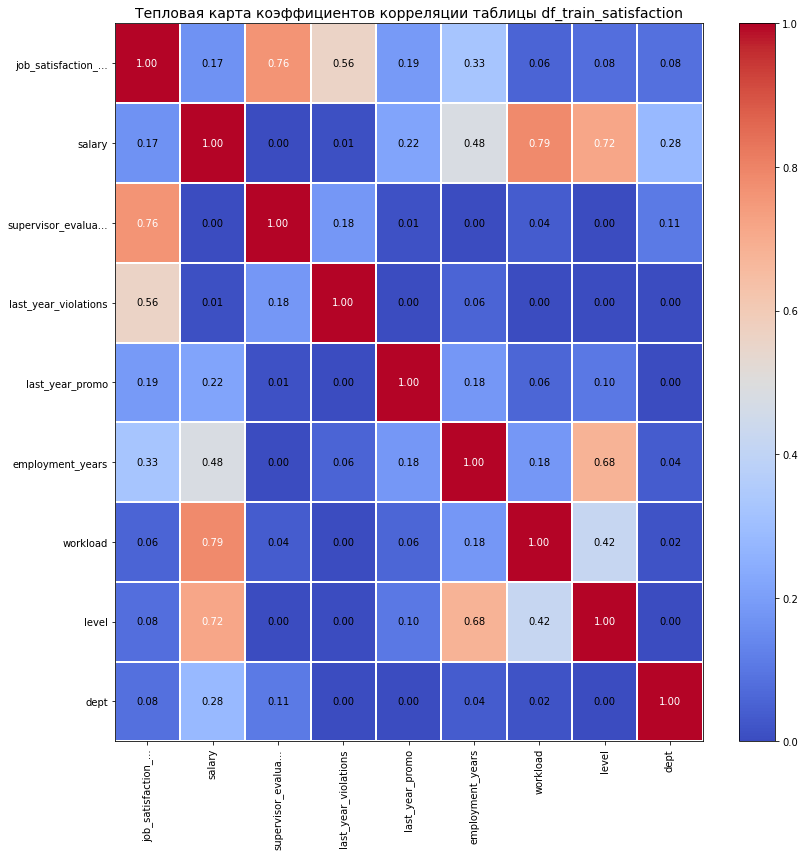

In [ ]:
phik_overview = df_train_satisfaction[corr_columns].phik_matrix(interval_cols=['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="coolwarm",
                        title="Тепловая карта коэффициентов корреляции таблицы df_train_satisfaction",
                        fontsize_factor=1,
                        figsize=(12, 12))
plt.tight_layout()
plt.show()

Очевидно следующее:
1. Мультиколлениарности нет.
2. Целевой признак job_satisfaction_rate относительно сильно коррелирует supervisor_evaluation и с last_year_violations, что не кажется странным.
3. Level коррелирует с employment_years, а salary c workload и level.

### Обучение моделей

#### Выбор модели

Приступим к выбору моделей в Pipeline. В нем учтем следующее:
1. Обработку пропусков.
2. Кодировку и масштабирование признаков.
3. Два вида моделей: дерево решений и линейную регрессию.
4. Для перебора гиперпараметров и моделей будем использовать grid, чтобы не упустить наиболее оптимальное решение.
5. В качестве первоначальной метрики при подборе модели будем использовать коэффициент детерминации r2 как наиболее близкий метрике SMAPE.

Разделим датафрайм на выборки.

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25


X_train, X_test, y_train, y_test = train_test_split(
    df_train_satisfaction.drop(['job_satisfaction_rate', 'id'], axis=1),
    df_train_satisfaction['job_satisfaction_rate'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df_train_satisfaction['job_satisfaction_rate'])

X_train.shape, X_test.shape

((3000, 8), (1000, 8))

Введем кодировщики для признаков в датафрейме.

In [ ]:
# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload', 'supervisor_evaluation']
num_columns = ['employment_years', 'salary']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='if_binary', handle_unknown='error', sparse=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    [1, 2, 3, 4, 5],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

Объединим всё в один Pipeline.

In [ ]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(2, 4),
        'models__min_weight_fraction_leaf': [0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },


    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

]


Переберем гиперпараметры и модели.

In [ ]:
%%time
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n',grid_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', grid_search.best_score_)

# проверка работы модели на тестовой выборке
y_test_pred = grid_search.predict(X_test)
print(f'Метрика r2 на тестовой выборке: {r2_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                          

По результатам перебора возможных комбинаций определено, что наилушая модель DecisionTreeRegressor со следующими параметрами: max_depth=19, max_features=12, min_samples_leaf=3, min_weight_fraction_leaf=0. Метрика r2 на кросс-валидационной выборке составила 0,87.

Сохраним модель и посчитаем метрику SMAPE с помощью отдельной функции.

In [ ]:
model = grid_search.best_estimator_.named_steps['models']

In [ ]:
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

In [ ]:
y_test_metric = y_test.reset_index(drop=True)

In [ ]:
custom_metric(y_test_metric, y_test_pred)

15.292352727189144

Метрика получилась выше 15, что больше нужного значения. Однако отклонение небольшое, поэтому проверим модель на тестовых данных.

#### Проверка модели на тестовых данных

Сделаем теперь прогноз на тестовых данных. Однако перед этим необходимо подготовить данные. Очевидно, что в данных разные id идут под разными индексами. Чтобы соблюсти соответствие, объединим таблицы.

In [ ]:
X_test_satis_preprocessed = preprocessor.transform(df_test_features_satisfaction.drop('id', axis=1))

In [ ]:
y_pred_satis=model.predict(X_test_satis_preprocessed)

In [ ]:
y_pred_satis = pd.DataFrame(y_pred_satis)

In [ ]:
df_test_full = df_test_features_satisfaction.join(y_pred_satis, how='left')

In [ ]:
df_test_full = df_test_full.merge(df_test_target_satisfaction, on='id', how='left')

Переименуем столбец с прогнозом.

In [ ]:
rename_pred = {0:'satisfaction_pred'}

In [ ]:
df_test_full = df_test_full.rename(columns=rename_pred)

Проверим результат

In [ ]:
df_test_full.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,satisfaction_pred,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.814286,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.690000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.697143,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.712000,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.760000,0.75


Всё сделанно корректно. Теперь посчитаем метрику:

In [ ]:
custom_metric(df_test_full['job_satisfaction_rate'], df_test_full['satisfaction_pred'])

14.14761904788697

Метрика получилась ниже установленного порога в 15, следовательно условие выполнено, модель обеспечивает нужную точность.

### Выводы по разделу "Прогнозирование уровня удовлетворенности"

По результатам проведенного моделирования установленно, что наилучшая модель: DecisionTreeRegressor. При этом глубина дерева получилась достаточно большой: max_depth=19. Это указывает на то, что модели приходится учитывать большое количество признаков для корректного вывода относительно уровня удовлетворенности. В самом деле, практически все признаки из начальной таблицы присутствовали при обучении модели, не считая id.  
Теперь посмотрим на влияние признаков на решение модели:

In [ ]:
shap_sample_satis = shap.sample(X_test_satis_preprocessed, 1)

NameError: name 'shap' is not defined

In [ ]:
explainer = shap.KernelExplainer(model.predict, shap_sample_satis)
shap_values_satis = explainer(X_test_satis_preprocessed)

  0%|          | 0/2000 [00:00<?, ?it/s]

Получим названия признаков для построения графиком.

In [ ]:
encoder = ohe_pipe['ohe']
# обучение кодирования на тренировочных данных
encoder.fit(X_train[ohe_columns].dropna())


cat_encoder = encoder.get_feature_names()

num_features = ['employment_years', 'salary']

ord_features = ['level', 'workload', 'supervisor_evaluation']

feature_names = np.concatenate([cat_encoder, ord_features, num_features])
feature_names

array(['x0_hr', 'x0_marketing', 'x0_purchasing', 'x0_sales',
       'x0_technology', 'x1_yes', 'x2_yes', 'level', 'workload',
       'supervisor_evaluation', 'employment_years', 'salary'],
      dtype=object)

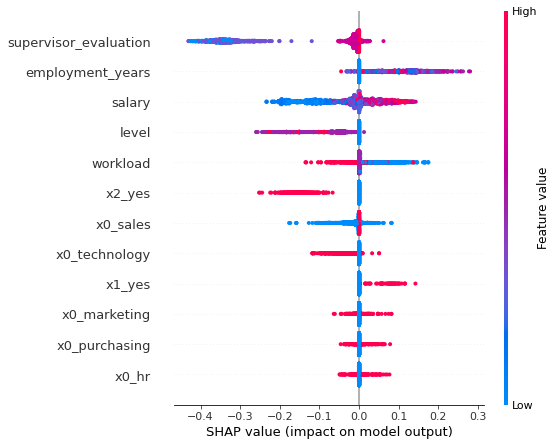

In [ ]:
shap.summary_plot(shap_values_satis, X_test_satis_preprocessed, feature_names=feature_names)

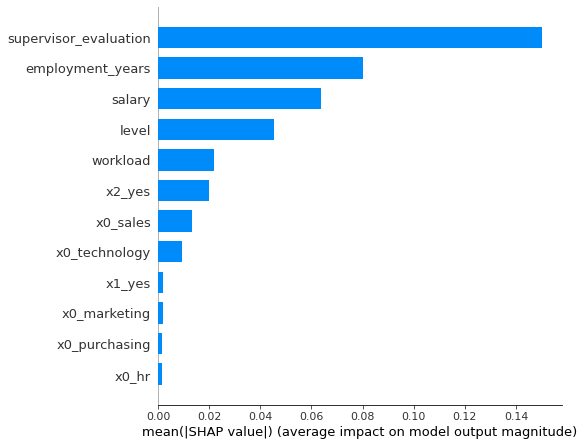

In [ ]:
shap.summary_plot(shap_values_satis, X_test_satis_preprocessed, plot_type="bar", feature_names=feature_names)

Наибольший вклад в решение модели вносит признак super_evaluation, то есть на удовлетворение от работы сильное влияние оказывает оценка руководителя. Второй по значимости признак - количество отработанных лет.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

## Задание 2. Прогнозирование вероятности увольнения сотрудника

### Загрузка данных

Сперва загрузим данные для задания.

In [ ]:
df_train_quit = pd.read_csv('/datasets/train_quit.csv')  # Новый входной признак
df_test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')  # Новый тестовой целевой признак

In [ ]:
df_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [ ]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [ ]:
df_test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [ ]:
df_test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Данные загружены, проверены, некорректных типов данных и пропусков нет.

### Предподготовка данных

В данных отсутствует информация по уровню удовлетворенности. Получим прогноз модели из Заданий для новых даннных.

In [ ]:
X_test_quit_preprocessed = preprocessor.transform(df_train_quit.drop(['id', 'quit'], axis=1))

In [ ]:
y_pred_quit=model.predict(X_test_quit_preprocessed)

In [ ]:
y_pred_quit = pd.DataFrame(y_pred_quit)

In [ ]:
df_train_quit = df_train_quit.join(y_pred_quit, how='left')

In [ ]:
df_train_quit = df_train_quit.rename(columns=rename_pred)

In [ ]:
df_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,satisfaction_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.647500
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.829412
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.480000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.353333
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.795000


Прогноз выполнен, в таблицу добавлен.

### Исследовательский анализ данных

Теперь посмотрим как соотносятся между собой величины. Спервы выделим столбцы для анализа.

In [ ]:
quit_columns = ['employment_years',
                'supervisor_evaluation',
                'salary',
                'satisfaction_pred'
               ]

In [ ]:
group_quit_columns = ['dept',
                      'level',
                      'workload',
                      'last_year_promo',
                      'last_year_violations',
                      'quit'
                     ]

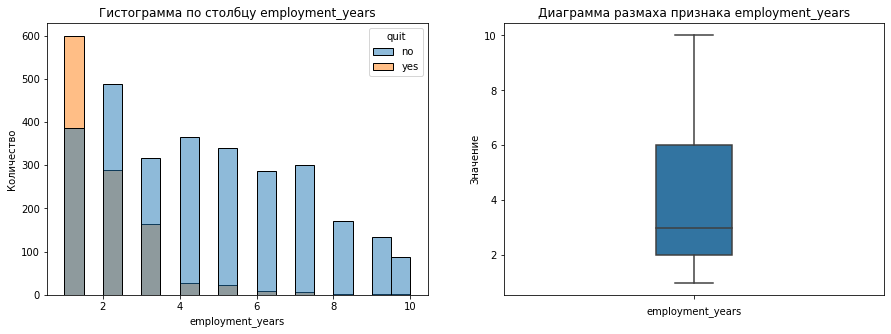

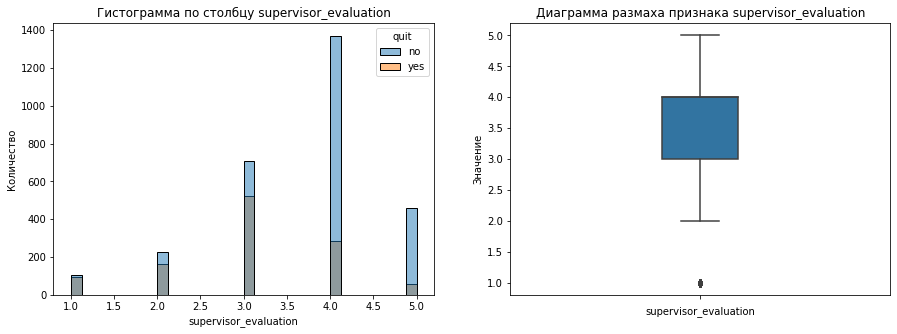

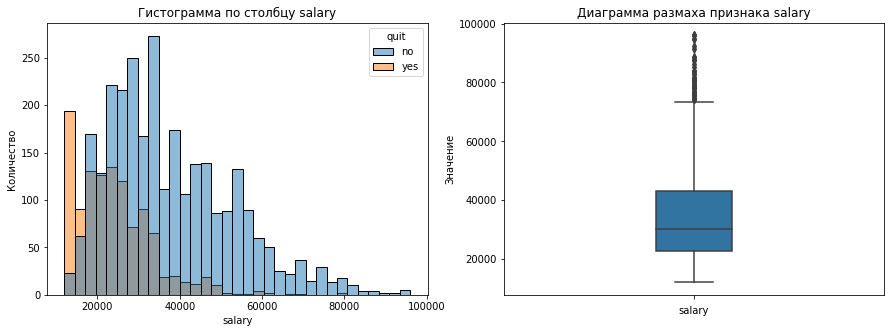

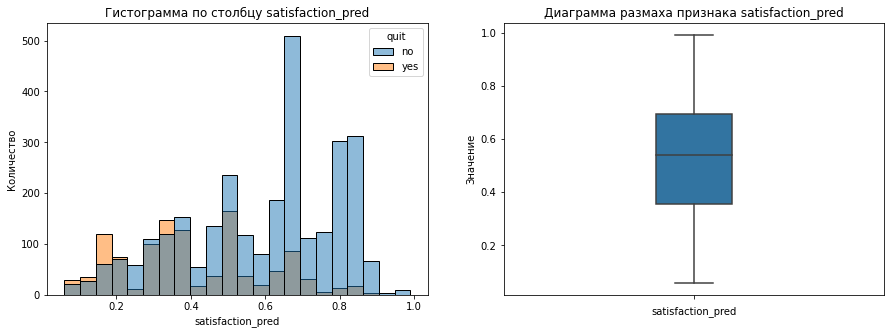

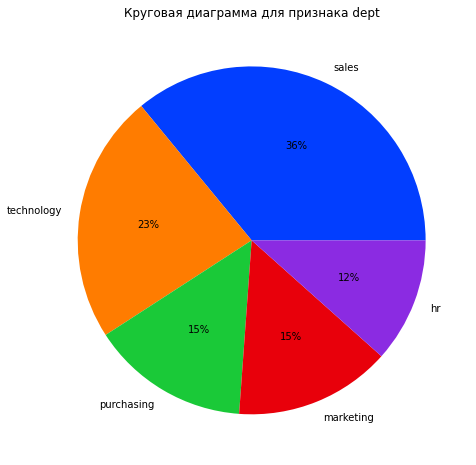

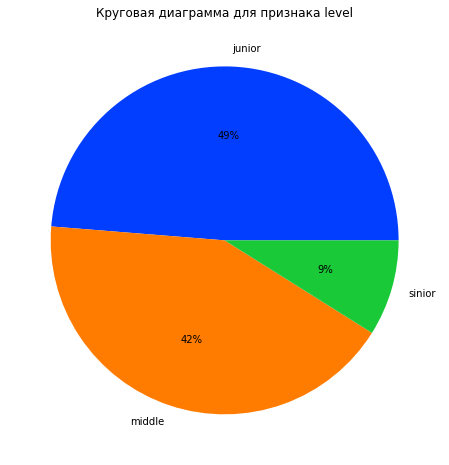

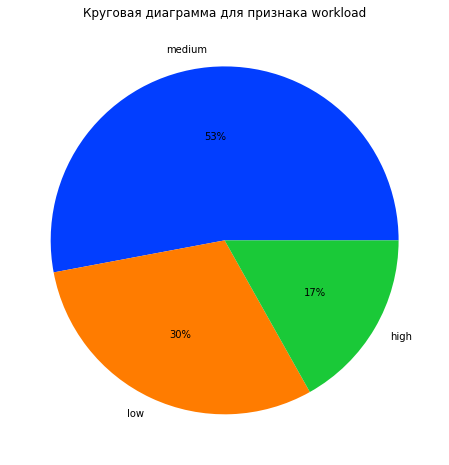

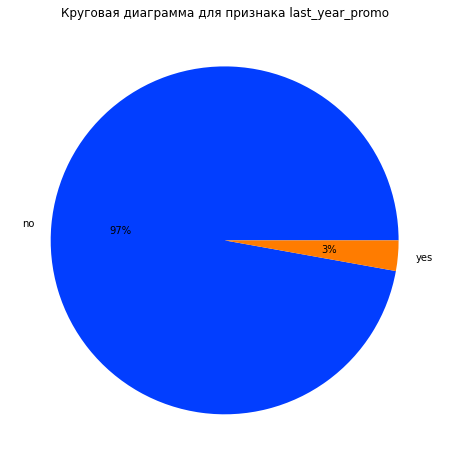

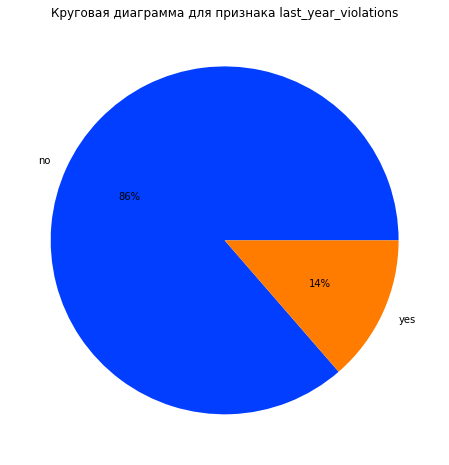

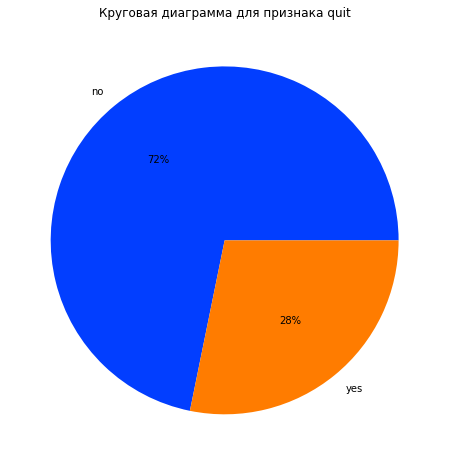

In [ ]:
lunge_analysis(df_train_quit, quit_columns, group_quit_columns, 'quit')

Из анализа очевидно следующее:
1. Чаще всего компанию покидают те, кто работает 1 год.
2. Есть выпады в столбце supervisor_evaluation так как, как и в первом задании.
3. В целом компанию чаще покидают те, кто имеет оценку 3 и ниже от руководителя.
4. В столбце salary также есть выпады, соответственно как и в первом задании.
5. Чаще всего компанию покидают те, кто получают относительно небольшую зарплату.
6. Чаще всего компанию покидают те, у кого прогнозируется низкая удовлетворенность.
7. Распределение данных очень похоже на распределение из первого задания.
8. 28% сотрудников готовы покинуть компанию.

### Корреляционный анализ

Посмотрим корреляцию между признаками. Для этого выделим признаки и построим тепловую карту методом phik.

In [ ]:
corr_columns_quit = ['dept',
                    'level',
                     'workload',
                     'employment_years',
                     'last_year_promo',
                     'last_year_violations',
                     'supervisor_evaluation',
                     'salary',
                     'quit',
                     'satisfaction_pred'
                    ]

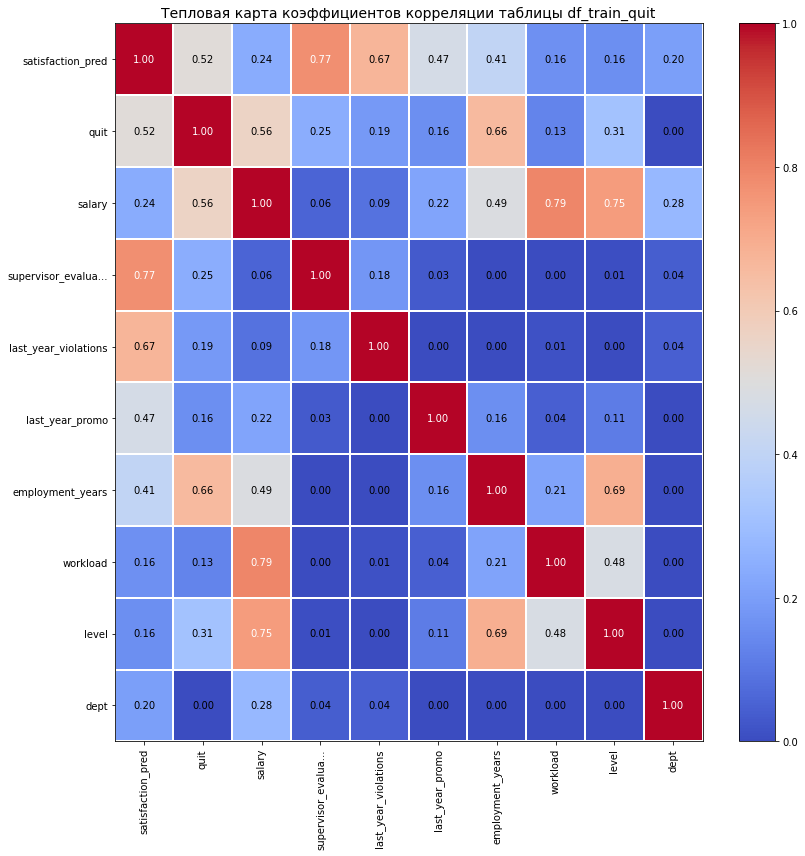

In [ ]:
phik_overview = df_train_quit[corr_columns_quit].phik_matrix(interval_cols=['employment_years', 'supervisor_evaluation', 'salary', 'satisfaction_pred'])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="coolwarm",
                        title="Тепловая карта коэффициентов корреляции таблицы df_train_quit",
                        fontsize_factor=1,
                        figsize=(12, 12))
plt.tight_layout()
plt.show()

Из тепловой карты видно:
1. Мультиколлениарности нет.
2. Целевой признак quit значительно коррелирует с предсказанным уровнем удовлетворенности, с salary и employment_years.
3. quit почти не коррелирует с dept. То есть вероятность ухода сотрудника одинакова во всех отделах компании.

### Обучение модели

Перед выбором модели закодируем целевой признак в тренеровочном и проверочном датафрейме.

In [ ]:
df_train_quit['num_quit'] = df_train_quit.apply(cat_quit, axis=1)

In [ ]:
df_test_target_quit['num_quit'] = df_test_target_quit.apply(cat_quit, axis=1)

Чтобы соблюсти порядок по id каждого сотрудника, создадим одну общую таблицу для проверки качества.

In [ ]:
df_test_quit_full = df_test_full.merge(df_test_target_quit, on='id', how='left')

In [ ]:
df_test_quit_full.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,satisfaction_pred,job_satisfaction_rate,quit,num_quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.814286,0.79,no,0
1,686555,hr,junior,medium,1,no,no,4,30000,0.690000,0.72,no,0
2,467458,sales,middle,low,5,no,no,4,19200,0.697143,0.64,no,0
3,418655,sales,middle,low,6,no,no,4,19200,0.712000,0.60,no,0
4,789145,hr,middle,medium,5,no,no,5,40800,0.760000,0.75,no,0


Таблица создана, целевой признак закодирован. После кодировки подберем и обучим модель в Pipeline. Будем использовать два Pipeline: один со всеми признаками и один только с некоторыми в целях улучшения метрики.

#### Модель с учетом всех признаков.

Сформируем Pipeline со всеми признаками.

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df_train_quit.drop(['quit', 'id', 'num_quit'], axis=1),
    df_train_quit['num_quit'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df_train_quit['num_quit'])

X_train.shape, X_test.shape

((3000, 9), (1000, 9))

In [ ]:
# сформируем списки с названиями признаков
ohe_columns = ['dept',
               'last_year_promo',
               'last_year_violations']
ord_columns = ['level',
               'workload',
               'supervisor_evaluation'
              ]
num_columns = ['employment_years',
                'salary',
                'satisfaction_pred'
              ]

# сформируем пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='if_binary', handle_unknown='error', sparse=False))
    ]
    )

# сформируем пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    [1, 2, 3, 4, 5],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# сформируем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [ ]:
# сформируем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver=['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky' 'sag', 'saga'],
            penalty='l2'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели SVC
    {
        'models':[svm.SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear'
                           'poly'
                           'rbf',
                           'sigmoid'
                          ],
        'models__C': range(1, 5),
        'models__degree': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]


In [ ]:
%%time

grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', grid_search.best_score_)


# проверим работу модели на тестовой выборке
preds = grid_search.predict_proba(X_test)

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, preds[:, 1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                          

Выделим модель и подготовку данных из Pipeline для дальнейшего расчета метрики.

In [ ]:
model_all_cat = grid_search.best_estimator_.named_steps['models']

In [ ]:
preprocessor_all_cat = grid_search.best_estimator_.named_steps['preprocessor']

In [ ]:
X_test_quit_preprocessed_all_cat = preprocessor_all_cat.transform(df_test_full.drop(['id', 'job_satisfaction_rate'], axis=1))

Посчитаем метрику ROC-AUC для модели, которая обучалась на всех признаках.

In [ ]:
preds_all_cat = model_all_cat.predict_proba(X_test_quit_preprocessed_all_cat)

In [ ]:
roc_auc_quit_test_all_cat = roc_auc_score(df_test_quit_full['num_quit'], preds_all_cat[:, 1])
roc_auc_quit_test_all_cat

0.9147232264564689

Метрика выше порога в 0,91.

#### Модель с учетом некоторых признаков.

Теперь попробуем выбрать лишь несколько признаков для улучшения метрики.

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df_train_quit.drop(['quit', 'id',
                        'num_quit',
                        'dept',
                        'last_year_promo',
                        'supervisor_evaluation',
                        'salary',
                       ], axis=1),
    df_train_quit['num_quit'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df_train_quit['num_quit'])

X_train.shape, X_test.shape

((3000, 5), (1000, 5))

In [ ]:
# сформируем списки с названиями признаков
ohe_columns = [#'dept',
               #'last_year_promo',
               'last_year_violations']
ord_columns = ['level',
               'workload',
               #'supervisor_evaluation'
              ]
num_columns = ['employment_years',
                #'salary',
                'satisfaction_pred'
              ]

# сформируем пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='if_binary', handle_unknown='error', sparse=False))
    ]
    )

# сформируем пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    #[1, 2, 3, 4, 5],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# сформируем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [ ]:
# сформируем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver=['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky' 'sag', 'saga'],
            penalty='l2'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели SVC
    {
        'models':[svm.SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear'
                           'poly'
                           'rbf',
                           'sigmoid'
                          ],
        'models__C': range(1, 5),
        'models__degree': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [ ]:
%%time



grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', grid_search.best_score_)


# проверим работу модели на тестовой выборке
preds = grid_search.predict_proba(X_test)

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, preds[:, 1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse=False))]),
                                                  ['last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
           

Наилучшая модель: DecisionTreeClassifier со следующими параметрами: max_depth=5, max_features=5, random_state=42. Метрика ROC-AUC на кросс-валидационной выборке получилась 0,92, что выше необходимого значения. Сохраним модель и подготовку данных из Pipeline.

In [ ]:
model_some_cat = grid_search.best_estimator_.named_steps['models']

In [ ]:
preprocessor_some_cat = grid_search.best_estimator_.named_steps['preprocessor']

Для проверки точности модели используем таблицу, полученную в конце первого задания. Предварительно нужно подготовить данные.

In [ ]:
X_test_quit_preprocessed_some_cat = preprocessor_some_cat.transform(df_test_full.drop(['id', 'job_satisfaction_rate', 'last_year_promo','supervisor_evaluation', 'dept', 'salary'], axis=1))

Теперь рассчитаем значение roc-auc для модели и проведем прогнозирование по тестовым данным.

In [ ]:
preds_some_cat = model_some_cat.predict_proba(X_test_quit_preprocessed_some_cat)

In [ ]:
roc_auc_quit_test_some_cat = roc_auc_score(df_test_quit_full['num_quit'], preds_some_cat[:, 1])
roc_auc_quit_test_some_cat

0.933901425354116

Метрика получилась ещё выше. Следовательно, эта модель наиболее оптимальная. Получим прогноз увольнения и добавим его в общую таблицу.

#### Добавление прогноза в общую таблицу

Лучшим оказался результат модели с учетом лишь некоторых параметров. Её и будем использовать.

In [ ]:
y_pred_quit=model_some_cat.predict(X_test_quit_preprocessed_some_cat)

Сведем в датафрейм, объединим таблицы и переименуем столбец.

In [ ]:
y_pred_quit = pd.DataFrame(y_pred_quit)

In [ ]:
df_test_quit_full = df_test_quit_full.join(y_pred_quit, how='left')

In [ ]:
rename_pred_quit_full = {0:'quit_pred'}

In [ ]:
df_test_quit_full = df_test_quit_full.rename(columns=rename_pred_quit_full)

Проверим переименование

In [ ]:
df_test_quit_full.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,satisfaction_pred,job_satisfaction_rate,quit,num_quit,quit_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.814286,0.79,no,0,0
1,686555,hr,junior,medium,1,no,no,4,30000,0.690000,0.72,no,0,0
2,467458,sales,middle,low,5,no,no,4,19200,0.697143,0.64,no,0,0
3,418655,sales,middle,low,6,no,no,4,19200,0.712000,0.60,no,0,0
4,789145,hr,middle,medium,5,no,no,5,40800,0.760000,0.75,no,0,0


Всё сделано корректно.

### Вывод по разделу "Прогнозирование вероятности увольнения"

По результатам разработки установлено, что наилучшей моделью является DecisionTreeClassifier. При этом её глубина равняется max_depth=5, что значительно меньше, чем у модели из первого задания. Следовательно, при прогнозировании модель учитывает меньше признаков. Кроме того, при обучении модели пришлось снижать количество признаков, подаваемых на вход. Лишние признаки значительно снижали качество модели.

In [ ]:
explainer = shap.KernelExplainer(model_some_cat.predict, X_test_quit_preprocessed_some_cat)
shap_values = explainer(X_test_quit_preprocessed_some_cat)

Using 2000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
all_feature_columns = [
    'last_year_violations',
    'level',
    'workload',
    'employment_years',
    'satisfaction_pred'
]

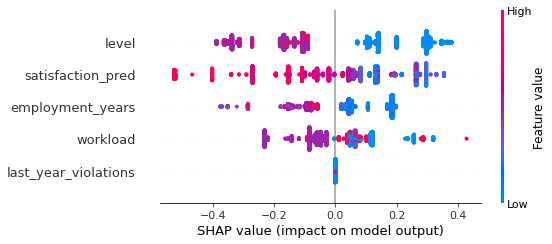

In [ ]:
shap.summary_plot(shap_values, X_test_quit_preprocessed_some_cat, feature_names=all_feature_columns)

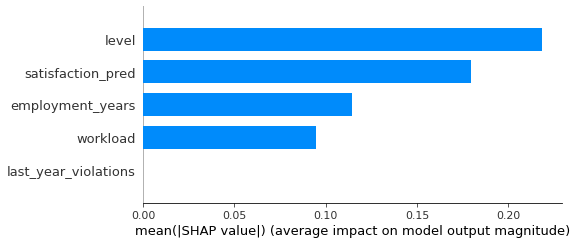

In [ ]:
shap.summary_plot(shap_values, X_test_quit_preprocessed_some_cat, feature_names=all_feature_columns, plot_type="bar")

Судя по диаграммам наибольший вклад вносит признак уровень позиции, которую занимает сотрудник. Это подтверждается предыдущими анализами: чаще всего компанию покидают те, кто работает на позиции junior. При этом признак о дисциплинарных взысканиях оказывает небольшое влияние.

## Общие выводы

**В рамках работы выполнено:**
1. Загружены и обработаны предоставленные данные.
2. Проведен исследовательский анализ данных на наличие аномальный и выпадающих значений.
3. Проведен корреляционный анализ данных.
4. Составлены и обучены ряд моделей для прогнозирования уровня удовлетворенности сотрудников и вероятности их увольнения.


**Основные результаты работы:**
1. В представленных данных не было пропусков, но были значения, значительно отклоняющиеся от средних.
2. Во время исследовательского анализа данных установлено следующее:
- Люди, которые работают на позиции junior, в большинстве своём работают недолго, до 4 лет.
- Чаще всего компанию покидают те, кто работает 1 год.
- В целом компанию чаще покидают те, кто имеет оценку 3 и ниже от руководителя.
- Чаще всего компанию покидают те, у кого прогнозируется низкая удовлетворенность.
- Особенности уровня удовлетворенности отмечаются только на диаграммах о последнем повышении и о нарушение трудового договора. Так, тех, у кого за последний год повысили, уровень удовлетворенности высокий, а те, которые были замечены за нарушением трудового договора уровень удовлетворенности низкий.
- 28% сотрудников готовы покинуть компанию.
3. При корреляционном анализы выявлено следующее:
- Удовлетворенность сотрудника относительно сильно коррелирует с оценков от руководителя supervisor_evaluation и с наличием нарушений договора за последний год.
- Вероятность увольнения сотрудника значительно коррелирует с предсказанным уровнем удовлетворенности, с зарплатой и с количеством отработанных лет.
- Вероятность ухода сотрудника из компании не коррелирует с отделом, где он работает.
3. Среди разработанных и испытанных моделей наилучшие:
- для прогнозирования уровня удовлетворенности DecisionTreeRegressor с параметрами max_depth=19, max_features=12, min_samples_leaf=3, min_weight_fraction_leaf=0.
- для прогнозирования вероятности увольнения DecisionTreeClassifier со следующими параметрами: max_depth=5, max_features=5.


**Рекомендации для увеличения удовлетворенности сотрудников:**
1. Разработать систему мотивации с поощрением в виде небольших повышений.
2. Рассмотреть возможность предотвращения нарушений трудового договора без необходимости дисциплинарного взыскания.

**Рекомендации для уменьшения вероятности увольнения сотрудников:**
1. Не допускать снижение уровня удовлетворенности сотрудника.
2. Для сотрудников, у которых высока вероятность увольнения, рассмотреть возможность поощрений.

**Рекомендации для повышения качества анализа и прогнозирования:**  
Представить данные за другие отделы или периоды опробирования моделей на новых данных.